In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Indexing and Loading the Dataset

We scan the folder structure to create a metadata DataFrame, capturing file paths, labels (real/fake), and sources. This provides a centralized view of the dataset, essential for handling large video collections. For Celeb-DF-v2, this reveals class imbalance (far more fakes than reals), which is common in deepfake datasets and can bias models toward over-detecting fakes. We also integrate the test list to separate evaluation data early, preventing data leakage.

In [9]:
base_path = 'Celeb-DF-v2'  # Replace with your actual path

# Define folders and labels
folders = {
    'real': ['Celeb-real', 'YouTube-real'],
    'fake': ['Celeb-synthesis']
}

# Collect file metadata
file_records = []
for label, subfolders in folders.items():
    for subfolder in subfolders:
        full_path = os.path.join(base_path, subfolder)
        if os.path.exists(full_path):
            for fname in os.listdir(full_path):
                if fname.endswith('.mp4'):
                    file_records.append({
                        'filename': fname,
                        'folder': subfolder,
                        'label': label,
                        'filepath': os.path.join(full_path, fname)
                    })
        else:
            print(f"Warning: Folder {full_path} not found.")

metadata = pd.DataFrame(file_records)

# Load and tag test videos
test_file = os.path.join(base_path, 'List_of_testing_videos.txt')
if os.path.exists(test_file):
    with open(test_file, 'r') as f:
        test_videos = {line.strip() for line in f if line.strip()}
    metadata['is_test'] = metadata.apply(
        lambda row: f"{row['folder']}/{row['filename']}" in test_videos, axis=1
    )
else:
    print("Warning: List_of_testing_videos.txt not found.")
    metadata['is_test'] = False

# Save metadata for reuse
metadata.to_csv('celeb_df_metadata.csv', index=False)
print(f"Total videos: {len(metadata)}")
metadata.head()

Total videos: 6529


,filename,folder,label,filepath,is_test
0,id60_0005.mp4,Celeb-real,real,Celeb-DF-v2/Celeb-real/id60_0005.mp4,False
1,id2_0004.mp4,Celeb-real,real,Celeb-DF-v2/Celeb-real/id2_0004.mp4,False
2,id43_0001.mp4,Celeb-real,real,Celeb-DF-v2/Celeb-real/id43_0001.mp4,False
3,id60_0002.mp4,Celeb-real,real,Celeb-DF-v2/Celeb-real/id60_0002.mp4,False
4,id35_0000.mp4,Celeb-real,real,Celeb-DF-v2/Celeb-real/id35_0000.mp4,False


In [11]:
# Compute and output dataset statistics
total_videos = len(metadata)
total_real = len(metadata[metadata['label'] == 'real'])
total_fake = len(metadata[metadata['label'] == 'fake'])
real_sources = metadata[metadata['label'] == 'real']['folder'].value_counts()
num_test = metadata['is_test'].sum()
percent_test = (num_test / total_videos) * 100 if total_videos > 0 else 0

print("\nDataset Composition Summary:")
print(f"Total videos in dataset: {total_videos}")
print(f"Total real videos: {total_real}")
print("  - Real videos breakdown by source:")
for source, count in real_sources.items():
    print(f"    {source}: {count}")
print(f"Total fake videos: {total_fake}")
print(f"Videos tagged as test: {num_test} ({percent_test:.2f}%)")


Dataset Composition Summary:
Total videos in dataset: 6529
Total real videos: 890
  - Real videos breakdown by source:
    Celeb-real: 590
    YouTube-real: 300
Total fake videos: 5639
Videos tagged as test: 0 (0.00%)


# Basic Data Overview and Summary Statistics

We examine the dataset's shape, datatypes, and basic stats to understand its composition. For videos, we extract properties like duration, resolution, and FPS. This reveals patterns (e.g., shorter videos might be easier to fake) and ensures consistency (e.g., all videos in MP4 format). In deepfake contexts, inconsistencies in resolution or FPS could indicate manipulation.

In [18]:
# Basic info
print(metadata.info())  # Datatypes and null counts
print(metadata.describe(include='all'))  # Summary stats

# Function to extract video properties
def extract_video_props(filepath):
    cap = cv2.VideoCapture(filepath)
    if not cap.isOpened():
        return pd.Series({'duration': np.nan, 'fps': np.nan, 'width': np.nan, 'height': np.nan, 'frame_count': np.nan})
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps if fps > 0 else np.nan
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    cap.release()
    return pd.Series({'duration': duration, 'fps': fps, 'width': width, 'height': height, 'frame_count': frame_count})

# Extract for a random sample (e.g., 100 videos)
sample_size = 100
sample = metadata.sample(100, random_state=42)
sample[['duration', 'fps', 'width', 'height', 'frame_count']] = sample['filepath'].apply(extract_video_props)
sample.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6529 entries, 0 to 6528
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6529 non-null   object
 1   folder    6529 non-null   object
 2   label     6529 non-null   object
 3   filepath  6529 non-null   object
 4   is_test   6529 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 210.5+ KB
None
             filename           folder label  \
count            6529             6529  6529   
unique           6529                3     2   
top     id60_0005.mp4  Celeb-synthesis  fake   
freq                1             5639  5639   

                                    filepath is_test  
count                                   6529    6529  
unique                                  6529       1  
top     Celeb-DF-v2/Celeb-real/id60_0005.mp4   False  
freq                                       1    6529  


,filename,folder,label,filepath,is_test,duration,fps,width,height,frame_count
4446,id28_id3_0000.mp4,Celeb-synthesis,fake,Celeb-DF-v2/Celeb-synthesis/id28_id3_0000.mp4,False,11.000000,30.0,844.0,472.0,330.0
2644,id33_id37_0004.mp4,Celeb-synthesis,fake,Celeb-DF-v2/Celeb-synthesis/id33_id37_0004.mp4,False,13.900000,30.0,848.0,466.0,417.0
334,id6_0009.mp4,Celeb-real,real,Celeb-DF-v2/Celeb-real/id6_0009.mp4,False,17.666667,30.0,942.0,500.0,530.0
5193,id6_id16_0005.mp4,Celeb-synthesis,fake,Celeb-DF-v2/Celeb-synthesis/id6_id16_0005.mp4,False,12.400000,30.0,944.0,500.0,372.0
1370,id17_id26_0005.mp4,Celeb-synthesis,fake,Celeb-DF-v2/Celeb-synthesis/id17_id26_0005.mp4,False,10.400000,30.0,894.0,500.0,312.0


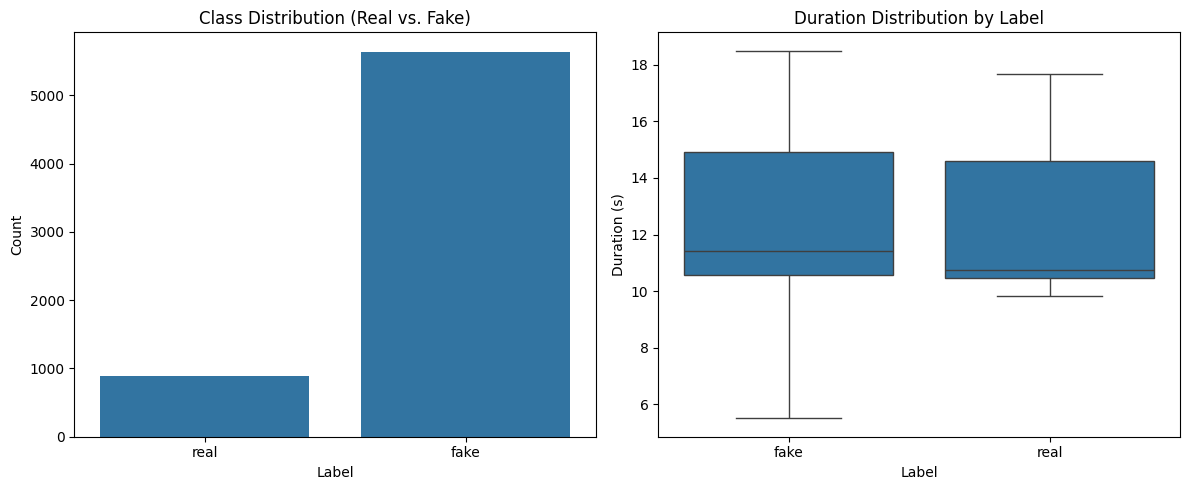

In [23]:
# Replace sample_df with your actual DataFrame (must contain 'label' and 'duration' columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart for class distribution
sns.countplot(x='label', data=metadata, ax=axes[0])
axes[0].set_title('Class Distribution (Real vs. Fake)')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

# Box plot for duration distribution by label (if you have extracted durations)
sns.boxplot(x='label', y='duration', data=sample, ax=axes[1])
axes[1].set_title('Duration Distribution by Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Duration (s)')

plt.tight_layout()
plt.show()

# Data Quality Checks (Missing Values, Duplicates, Outliers)

We identify issues like missing data, duplicates, or outliers that could skew analysis. For videos, outliers might be unusually long/short clips or low-resolution files. In deepfake detection, duplicates could lead to overfitting, and outliers (e.g., noisy videos) might introduce bias. This step ensures a clean dataset.

In [16]:
# Missing values
print("Missing values:\n", metadata.isnull().sum())

# Duplicates (by filename or path)
print("Duplicate filenames:", metadata.duplicated('filename').sum())
print("Duplicate paths:", metadata.duplicated('filepath').sum())

# Outliers (e.g., in duration from sample)
Q1 = sample['duration'].quantile(0.25)
Q3 = sample['duration'].quantile(0.75)
IQR = Q3 - Q1
outliers = sample[(sample['duration'] < (Q1 - 1.5 * IQR)) | (sample['duration'] > (Q3 + 1.5 * IQR))]
print("Outliers in duration:\n", outliers)

# Handling example: Drop duplicates and fill missing durations with median
metadata = metadata.drop_duplicates('filepath')
sample['duration'].fillna(sample['duration'].median(), inplace=True)
sample.fillna({'duration'}, sample['duration'].median(), inplace=True)

Missing values:
 filename    0
folder      0
label       0
filepath    0
is_test     0
dtype: int64
Duplicate filenames: 0
Duplicate paths: 0
Outliers in duration:
 Empty DataFrame
Columns: [filename, folder, label, filepath, is_test, duration, fps, width, height, frame_count]
Index: []


/tmp/ipykernel_12738/1486890952.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample['duration'].fillna(sample['duration'].median(), inplace=True)
